## Define different types of users
Active versus inactive 

0 versus 1

First hypothesis:
- you are inactive if you have less than 5 trips in two months

Second hypothesis:
- you are inactive if you have less than 50 miles in two months

### We have comb through everyone and determine whether they are active or inactive 

In [117]:
from __future__ import division
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans


import chart_studio
import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import datetime

In [118]:
# create dataframes
driver = pd.read_csv("driver_ids.csv")
rider = pd.read_csv("ride_ids.csv")
timestamps = pd.read_csv("ride_timestamps.csv")

In [119]:
driver[driver['driver_id']== '056175954c78be4c4de7e80167b7e1f9']

,driver_id,driver_onboard_date


In [120]:
rider.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100


In [121]:
timestamps.head()

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05


## Cleaning the rider df
- durations into minutes 
- distance into miles 
- fare based on minutes
- fare based on distance
- Actual total fare

In [122]:
# Convert the seconds into mintues 
rider['duration_min'] = rider['ride_duration'].apply(lambda x: x / 60)

In [123]:
# Convert meters into miles 
rider['distance_mi'] = rider['ride_distance'].apply(lambda x: x *  0.00062137)

In [124]:
# The fare purely based on the length in minutes 
rider['fare_duration'] = rider['duration_min'].apply(lambda x: x * .22)

In [125]:
# The fare purely based on the distance 
rider['fare_distance'] = rider['distance_mi'].apply(lambda x: x * 1.15)

In [126]:
# Fare based on the formula presented online
rider['total_fare'] = ((rider['fare_distance'] + rider['fare_duration']) * (1 + (0.01 * rider['ride_prime_time']))) + 2 + 1.75


In [127]:
# Set minimum and maximum on the fares 
rider['total_fare'] = rider['total_fare'].apply(lambda x: x if x >= 5 else 5)
rider['total_fare'] = rider['total_fare'].apply(lambda x: x if x <= 400 else 400)

In [128]:
rider.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,duration_min,distance_mi,fare_duration,fare_distance,total_fare
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,5.450000,1.125301,1.199000,1.294096,7.489644
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,13.483333,2.089046,2.966333,2.402403,9.118736
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,9.533333,2.039336,2.097333,2.345237,8.192570
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,55.633333,40.564898,12.239333,46.649632,77.361207
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,13.716667,2.556938,3.017667,2.940478,15.666290


## Combining timestamp and onboarding dates 


In [129]:
timestamps.head()

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05


In [130]:
# pivot the timestamps
pivot_timestamps = timestamps.pivot(index='ride_id', columns='event', values='timestamp')
pivot_timestamps.count()

event
accepted_at       194081
arrived_at        194080
dropped_off_at    194081
picked_up_at      194081
requested_at      194081
dtype: int64

In [131]:
# Preview the rides and the time stamp of each action 
pivot_timestamps.head()
pivot_timestamps.reset_index(level=0, inplace=True)
merged_driver = pd.merge(rider,pivot_timestamps,on = 'ride_id', how = 'inner')

## This contains three crucial elements 
- driver_id
- ride_id
- driver_onboarding_date

In [99]:
# Merge driver_id, ride_id, and onboarding_date
driver_rider = pd.merge(rider[['driver_id','ride_id']], driver, on = 'driver_id', how = 'inner')
driver_rider.head()

,driver_id,ride_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,2016-03-29 00:00:00
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2016-03-29 00:00:00
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,2016-03-29 00:00:00
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,2016-03-29 00:00:00
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,2016-03-29 00:00:00


In [100]:
# merged the two data frames 
timestamps_driver = pd.merge(pivot_timestamps,driver_rider, on = 'ride_id', how = 'inner')
timestamps_driver.head()

,ride_id,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at,driver_id,driver_onboard_date
0,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 10:03:05,2016-06-13 09:44:33,2016-06-13 09:39:19,d967f5296732fa55266b5f1314e7447b,2016-04-09 00:00:00
1,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:34:17,2016-05-14 05:26:18,2016-05-14 05:23:21,0656192a402808805282e60761bda088,2016-04-30 00:00:00
2,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:54:18,2016-05-16 15:47:32,2016-05-16 15:43:09,c468a648519cd42da75e6aa9dadf733e,2016-04-01 00:00:00
3,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:40:47,2016-05-11 19:35:15,2016-05-11 19:29:36,689bdf87fb2de49f98bf4946cfaa5068,2016-04-04 00:00:00
4,00012759befd5d34a0609800f6a1ee59,2016-05-31 15:45:05,2016-05-31 15:46:22,2016-05-31 15:59:26,2016-05-31 15:46:23,2016-05-31 15:44:56,eece82fe623b4bb335a9b9e20eb0ca54,2016-04-28 00:00:00


In [18]:
# Reorder the columns
timestamps_driver = timestamps_driver[['driver_id', 'driver_onboard_date', 'ride_id','requested_at', 'accepted_at', 'arrived_at', 'picked_up_at', 'dropped_off_at']]
timestamps_driver.head()#['driver_onboard_date'][0]
timestamps_driver.picked_up_at.dtype
timestamps_driver['picked_up_at'] = pd.to_datetime(timestamps_driver['picked_up_at'].str.strip(), format='%Y-%m-%d %H:%M:%S')

In [19]:
# Create a new dataframe  
timestamps_driver_datetime = pd.DataFrame()


# Change them into timestamp dates 
timestamps_driver_datetime['driver_id'] = timestamps_driver['driver_id']

timestamps_driver_datetime['driver_onboard_date'] = pd.to_datetime(timestamps_driver['driver_onboard_date'])

timestamps_driver_datetime['ride_id'] = timestamps_driver['ride_id']

timestamps_driver_datetime['requested_at'] = pd.to_datetime(timestamps_driver['requested_at'])

timestamps_driver_datetime['accepted_at'] = pd.to_datetime(timestamps_driver['accepted_at'])

timestamps_driver_datetime['arrived_at'] = pd.to_datetime(timestamps_driver['arrived_at'])

timestamps_driver_datetime['picked_up_at'] = pd.to_datetime(timestamps_driver['picked_up_at'])

timestamps_driver_datetime['dropped_off_at'] = pd.to_datetime(timestamps_driver['dropped_off_at'])


timestamps_driver_datetime.head()
timestamps_driver[timestamps_driver['driver_id'] == '002be0ffdc997bd5c50703158b7c2491'].max()

driver_id              002be0ffdc997bd5c50703158b7c2491
driver_onboard_date                 2016-03-29 00:00:00
ride_id                ff72b2fbf16a0ab06fe8cec71e50eb50
requested_at                        2016-06-23 10:06:26
accepted_at                         2016-06-23 10:06:30
arrived_at                          2016-06-23 10:08:03
picked_up_at                        2016-06-23 10:08:13
dropped_off_at                      2016-06-23 10:29:53
dtype: object

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



,driver_id,ride_id,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at
driver_onboard_date,,,,,,,
2016-03-28,3849,3849,3849,3849,3849,3849,3849
2016-03-29,6937,6937,6937,6937,6936,6937,6937
2016-03-30,6001,6001,6001,6001,6001,6001,6001
2016-03-31,7199,7199,7199,7199,7199,7199,7199
2016-04-01,3294,3294,3294,3294,3294,3294,3294


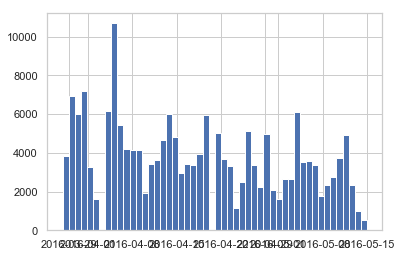

In [20]:
#timestamps_driver_datetime[timestamps_driver_datetime['driver_id'] == 'd967f5296732fa55266b5f1314e7447b'].count()

hist = timestamps_driver_datetime['driver_onboard_date'].hist(bins=50)

onboarding_amount = timestamps_driver_datetime.groupby(['driver_onboard_date']).count()
onboarding_amount.head()

In [21]:
# create a new data frame to contain frequency of riders 
df = pd.DataFrame()

df = rider.groupby(['driver_id'], as_index=False).size()

df = df.to_frame().reset_index()
df = df.rename(columns= {0: 'rides'})
df.head()

,driver_id,rides
0,002be0ffdc997bd5c50703158b7c2491,277
1,007f0389f9c7b03ef97098422f902e62,31
2,011e5c5dfc5c2c92501b8b24d47509bc,34
3,0152a2f305e71d26cc964f8d4411add9,191
4,01674381af7edd264113d4e6ed55ecda,375


In [22]:
# Create a dictionary of all the drivers as the key and the list of dates as a value
driver_ridedates = {}
for driver_id in df['driver_id']:
    # This is the dataframe with all the rides of a particular rider 
    temp_ride = timestamps_driver_datetime[timestamps_driver_datetime['driver_id'] == driver_id]
    
    #print(temp_ride.head())
    if temp_ride.shape[0] == 0:
        driver_ridedates[driver_id] = ['empty']
    elif temp_ride.shape[0] != 0:
        driver_ridedates[driver_id] = [temp_ride['driver_onboard_date'].tolist()[0]]
        driver_ridedates[driver_id].append(temp_ride['picked_up_at'].tolist())
        driver_ridedates[driver_id][1].sort()


In [23]:
driver_ridedates['056175954c78be4c4de7e80167b7e1f9']

driver_ridedates['056175954c78be4c4de7e80167b7e1f9']

['empty']

In [24]:
end = datetime.datetime(2016, 6, 27, 0, 0)

t = {}
for driver_id in df['driver_id']:
    if driver_ridedates[driver_id] == ['empty']:
        t[driver_id] = 0
    else:     
        t[driver_id] = ((abs(driver_ridedates[driver_id][0] 
                                         - end))).days 
t.values()

dict_values([90, 90, 83, 65, 59, 81, 51, 62, 52, 55, 88, 79, 76, 54, 78, 76, 83, 81, 44, 73, 0, 46, 80, 46, 58, 47, 68, 80, 44, 84, 50, 72, 68, 89, 55, 83, 45, 75, 90, 67, 47, 0, 84, 0, 0, 55, 90, 84, 74, 78, 62, 44, 47, 0, 88, 83, 83, 66, 63, 47, 64, 62, 60, 53, 0, 89, 72, 84, 90, 70, 70, 70, 68, 0, 53, 81, 90, 44, 44, 0, 0, 51, 84, 82, 0, 0, 69, 52, 89, 56, 0, 72, 67, 83, 88, 67, 83, 84, 83, 0, 84, 68, 0, 0, 45, 47, 57, 68, 0, 77, 0, 0, 79, 68, 83, 0, 62, 44, 84, 45, 75, 68, 0, 58, 0, 75, 47, 62, 60, 72, 63, 88, 87, 0, 88, 0, 68, 53, 82, 0, 56, 83, 79, 74, 49, 59, 68, 88, 90, 0, 81, 86, 45, 81, 67, 73, 51, 77, 75, 81, 83, 51, 80, 76, 55, 90, 62, 63, 0, 65, 0, 82, 0, 90, 74, 90, 66, 79, 43, 64, 87, 81, 84, 66, 80, 0, 82, 0, 53, 0, 59, 77, 61, 64, 74, 86, 88, 59, 73, 60, 45, 65, 47, 59, 84, 46, 84, 69, 0, 59, 0, 63, 69, 61, 71, 66, 84, 62, 86, 81, 0, 71, 65, 72, 61, 58, 0, 0, 56, 66, 56, 89, 63, 84, 67, 87, 74, 45, 81, 74, 59, 0, 83, 73, 74, 44, 51, 54, 46, 87, 83, 70, 89, 49, 73, 80, 

In [25]:
# The boolean is based on whether they had at least 5 rides per week average
# False means they didn't have enough 
# True means they reached the 5 rides a week quota 

driver_status = {}
for driver_id in df['driver_id']:
    if driver_ridedates[driver_id] == ['empty']:
        driver_status[driver_id] = False
    else:     
        driver_status[driver_id] = ((abs(driver_ridedates[driver_id][0] 
                                         - driver_ridedates[driver_id][1][-1])/7)*5).days <= len(driver_ridedates[driver_id][1])

In [26]:
# This just shows the amount of days between the initial onboarding and the last ride they accepted

driver_status_distance = {}
for driver_id in df['driver_id']:
    if driver_ridedates[driver_id] == ['empty']:
        driver_status_distance[driver_id] = 0
    else:     
        driver_status_distance[driver_id] = ((abs(driver_ridedates[driver_id][0] 
                                         - driver_ridedates[driver_id][1][-1]))).days 

In [27]:
#list(driver_status_distance.values())
#list(driver_status_distance)



In [28]:
driver_status_df = pd.DataFrame()

driver_status_df['driver_id'] = list(driver_status)

driver_status_df['driver_status'] = list(driver_status.values())

driver_status_df.head()

,driver_id,driver_status
0,002be0ffdc997bd5c50703158b7c2491,True
1,007f0389f9c7b03ef97098422f902e62,False
2,011e5c5dfc5c2c92501b8b24d47509bc,False
3,0152a2f305e71d26cc964f8d4411add9,True
4,01674381af7edd264113d4e6ed55ecda,True


In [29]:
driver_status_distance_df = pd.DataFrame()

driver_status_distance_df['driver_id'] = list(driver_status_distance)

driver_status_distance_df['driver_lifespan'] = list(driver_status_distance.values())

driver_status_distance_df['t'] = list(t.values())

driver_status_distance_df.head()


,driver_id,driver_lifespan,t
0,002be0ffdc997bd5c50703158b7c2491,86,90
1,007f0389f9c7b03ef97098422f902e62,85,90
2,011e5c5dfc5c2c92501b8b24d47509bc,68,83
3,0152a2f305e71d26cc964f8d4411add9,64,65
4,01674381af7edd264113d4e6ed55ecda,56,59


In [30]:
np.mean(driver_status_distance_df['driver_lifespan'])

49.2017075773746

timestamps_driver.count()

In [31]:
timestamps_driver.head()
recent_date = timestamps_driver['picked_up_at'].min()
recent_date

Timestamp('2016-03-28 06:02:39')

## Use survival analytics to predict lifetime

In [32]:
driver_status_df.head()

,driver_id,driver_status
0,002be0ffdc997bd5c50703158b7c2491,True
1,007f0389f9c7b03ef97098422f902e62,False
2,011e5c5dfc5c2c92501b8b24d47509bc,False
3,0152a2f305e71d26cc964f8d4411add9,True
4,01674381af7edd264113d4e6ed55ecda,True


In [33]:
#lambda x: 1 if x == False else 0

In [34]:
driver_status_df['driver_status_bool'] = driver_status_df['driver_status'].apply(lambda x: 1 if x == False else 0)

In [35]:
driver_status_df.head()

,driver_id,driver_status,driver_status_bool
0,002be0ffdc997bd5c50703158b7c2491,True,0
1,007f0389f9c7b03ef97098422f902e62,False,1
2,011e5c5dfc5c2c92501b8b24d47509bc,False,1
3,0152a2f305e71d26cc964f8d4411add9,True,0
4,01674381af7edd264113d4e6ed55ecda,True,0


In [36]:
driver_status_distance_df.head()
driver_status_distance_df = driver_status_distance_df[driver_status_distance_df['driver_lifespan'] != 0]

In [37]:
# Survival Analysis Data Frame  
survival_dataframe = pd.merge(driver_status_df,driver_status_distance_df, on = 'driver_id', how = 'inner')

survival_dataframe.head()

,driver_id,driver_status,driver_status_bool,driver_lifespan,t
0,002be0ffdc997bd5c50703158b7c2491,True,0,86,90
1,007f0389f9c7b03ef97098422f902e62,False,1,85,90
2,011e5c5dfc5c2c92501b8b24d47509bc,False,1,68,83
3,0152a2f305e71d26cc964f8d4411add9,True,0,64,65
4,01674381af7edd264113d4e6ed55ecda,True,0,56,59


In [38]:
from lifelines import KaplanMeierFitter


In [39]:
# create a kmf object
kmf = KaplanMeierFitter() 

In [40]:
# Fit the data into the model
kmf.fit(survival_dataframe['driver_lifespan'], survival_dataframe['driver_status_bool'],label='Kaplan Meier Estimate')

<lifelines.KaplanMeierFitter: fitted with 837 observations, 765 censored>

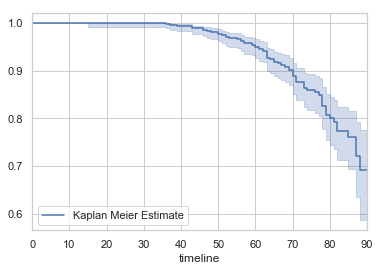

In [41]:
# Create an estimate
kmf.plot(ci_show=True) 



## ci_show is meant for Confidence interval, since our data set is too tiny, thus i am not showing it.

In [42]:
survival_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 0 to 836
Data columns (total 5 columns):
driver_id             837 non-null object
driver_status         837 non-null bool
driver_status_bool    837 non-null int64
driver_lifespan       837 non-null int64
t                     837 non-null int64
dtypes: bool(1), int64(3), object(1)
memory usage: 33.5+ KB


## Cox Proportional Hazard Model


In [43]:
from lifelines import CoxPHFitter


### Advice 1
Your team should recommend a definition, methodology or framework for calculating lifetime value.  Ideally, your recommendation should help you calculate a lifetime value for each individual driver.


### Advice 2
One of our follow up questions in the prompt is "Do all drivers act alike?  Are there specific segments of drivers that generate more value for Lyft than the average driver?".  So your LTV definition should be able to distinguish different drivers or at least cohorts of drivers. 


In [44]:
rider.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,duration_min,distance_mi,fare_duration,fare_distance,total_fare
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,5.450000,1.125301,1.199000,1.294096,7.489644
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,13.483333,2.089046,2.966333,2.402403,9.118736
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,9.533333,2.039336,2.097333,2.345237,8.192570
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,55.633333,40.564898,12.239333,46.649632,77.361207
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,13.716667,2.556938,3.017667,2.940478,15.666290


In [45]:
df.head()

,driver_id,rides
0,002be0ffdc997bd5c50703158b7c2491,277
1,007f0389f9c7b03ef97098422f902e62,31
2,011e5c5dfc5c2c92501b8b24d47509bc,34
3,0152a2f305e71d26cc964f8d4411add9,191
4,01674381af7edd264113d4e6ed55ecda,375


In [46]:
driver_status_distance_df.head()

,driver_id,driver_lifespan,t
0,002be0ffdc997bd5c50703158b7c2491,86,90
1,007f0389f9c7b03ef97098422f902e62,85,90
2,011e5c5dfc5c2c92501b8b24d47509bc,68,83
3,0152a2f305e71d26cc964f8d4411add9,64,65
4,01674381af7edd264113d4e6ed55ecda,56,59


In [47]:
# Create a dataframe with the range of onboard to most recent ride &
# the number of rides each driver has given 
rides_per_day = pd.merge(df,driver_status_distance_df, on = 'driver_id', how = 'inner')
rides_per_day.head()

,driver_id,rides,driver_lifespan,t
0,002be0ffdc997bd5c50703158b7c2491,277,86,90
1,007f0389f9c7b03ef97098422f902e62,31,85,90
2,011e5c5dfc5c2c92501b8b24d47509bc,34,68,83
3,0152a2f305e71d26cc964f8d4411add9,191,64,65
4,01674381af7edd264113d4e6ed55ecda,375,56,59


In [48]:
# Add a new column that averages the number of rides a driver has per day 

rides_per_day['rides_per_day'] = (rides_per_day['rides'] / rides_per_day['driver_lifespan']) 

rides_per_day.head()

,driver_id,rides,driver_lifespan,t,rides_per_day
0,002be0ffdc997bd5c50703158b7c2491,277,86,90,3.220930
1,007f0389f9c7b03ef97098422f902e62,31,85,90,0.364706
2,011e5c5dfc5c2c92501b8b24d47509bc,34,68,83,0.500000
3,0152a2f305e71d26cc964f8d4411add9,191,64,65,2.984375
4,01674381af7edd264113d4e6ed55ecda,375,56,59,6.696429


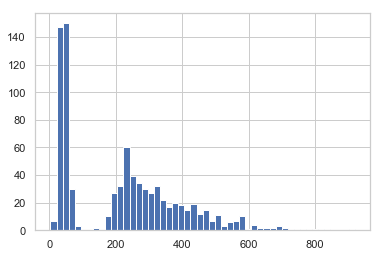

In [49]:
rides_per_day

hist = rides_per_day['rides'].hist(bins=50)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


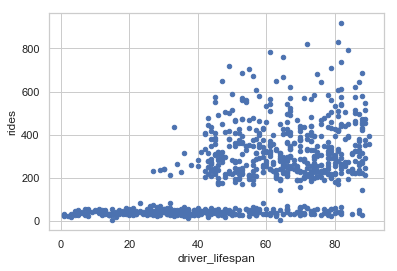

In [50]:
ax = rides_per_day.plot.scatter(x='driver_lifespan',
                       y='rides')

In [51]:
rider.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,duration_min,distance_mi,fare_duration,fare_distance,total_fare
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,5.450000,1.125301,1.199000,1.294096,7.489644
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,13.483333,2.089046,2.966333,2.402403,9.118736
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,9.533333,2.039336,2.097333,2.345237,8.192570
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,55.633333,40.564898,12.239333,46.649632,77.361207
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,13.716667,2.556938,3.017667,2.940478,15.666290


In [52]:
# Drop unneccessary columns
drive_sum = rider.drop(['ride_distance', 'ride_duration', 'fare_duration', 'fare_distance'], axis = 1)
# Group the riders by the sum 
drive_sum = drive_sum.groupby(['driver_id'],as_index=False).sum()

# Rename the columns to let people know that it's the sum of all rides 
drive_sum = drive_sum.rename(columns={"ride_prime_time": "ride_prime_time_sum", "duration_min": "duration_min_sum", "distance_mi":"distance_mi_sum", "fare":"fare_sum"})
drive_sum.head()

,driver_id,ride_prime_time_sum,duration_min_sum,distance_mi_sum,total_fare
0,002be0ffdc997bd5c50703158b7c2491,5375,3687.300000,1081.362133,3453.419687
1,007f0389f9c7b03ef97098422f902e62,625,341.616667,73.030237,308.994506
2,011e5c5dfc5c2c92501b8b24d47509bc,675,486.750000,167.554285,468.927442
3,0152a2f305e71d26cc964f8d4411add9,2050,2908.683333,914.183777,2569.866550
4,01674381af7edd264113d4e6ed55ecda,4700,5957.383333,1940.938672,5287.086873


In [53]:
driver_sum_total_fare = pd.merge(drive_sum,rides_per_day, on = 'driver_id', how = 'inner')
driver_sum_total_fare.head()
#driver_sum_total_fare[driver_sum_total_fare['driver_lifespan'] == 0]

,driver_id,ride_prime_time_sum,duration_min_sum,distance_mi_sum,total_fare,rides,driver_lifespan,t,rides_per_day
0,002be0ffdc997bd5c50703158b7c2491,5375,3687.300000,1081.362133,3453.419687,277,86,90,3.220930
1,007f0389f9c7b03ef97098422f902e62,625,341.616667,73.030237,308.994506,31,85,90,0.364706
2,011e5c5dfc5c2c92501b8b24d47509bc,675,486.750000,167.554285,468.927442,34,68,83,0.500000
3,0152a2f305e71d26cc964f8d4411add9,2050,2908.683333,914.183777,2569.866550,191,64,65,2.984375
4,01674381af7edd264113d4e6ed55ecda,4700,5957.383333,1940.938672,5287.086873,375,56,59,6.696429


In [54]:
timestamps_driver

,driver_id,driver_onboard_date,ride_id,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at
0,d967f5296732fa55266b5f1314e7447b,2016-04-09 00:00:00,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:19,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 09:44:33,2016-06-13 10:03:05
1,0656192a402808805282e60761bda088,2016-04-30 00:00:00,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:21,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:26:18,2016-05-14 05:34:17
2,c468a648519cd42da75e6aa9dadf733e,2016-04-01 00:00:00,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:09,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:47:32,2016-05-16 15:54:18
3,689bdf87fb2de49f98bf4946cfaa5068,2016-04-04 00:00:00,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:36,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:35:15,2016-05-11 19:40:47
4,eece82fe623b4bb335a9b9e20eb0ca54,2016-04-28 00:00:00,00012759befd5d34a0609800f6a1ee59,2016-05-31 15:44:56,2016-05-31 15:45:05,2016-05-31 15:46:22,2016-05-31 15:46:23,2016-05-31 15:59:26
...,...,...,...,...,...,...,...,...
184204,5ccc0e6dc9c7475caf785cdce7b8eb7a,2016-04-05 00:00:00,fffe942c46a5b2039fa01ba4c3d390e8,2016-05-17 19:56:09,2016-05-17 19:56:13,2016-05-17 19:58:50,2016-05-17 19:58:52,2016-05-17 20:11:11
184205,fb903879c556260ae2604ae0c45cb92a,2016-05-02 00:00:00,fffebb46effb90ce758fdff68b569355,2016-06-16 09:57:07,2016-06-16 09:57:12,2016-06-16 09:58:54,2016-06-16 09:58:57,2016-06-16 10:15:08
184206,3a1d9fb7a8cfd55ae38d1b4fb1520d1f,2016-05-02 00:00:00,ffff9c38173ddfa17bdd115c463e329f,2016-06-03 18:34:00,2016-06-03 18:34:07,2016-06-03 18:35:20,2016-06-03 18:35:22,2016-06-03 18:50:08
184207,36de1e085fbd8f354dd3192571cece32,2016-04-19 00:00:00,ffff9e431f7fade54b2550ac19ab6e64,2016-06-12 04:00:10,2016-06-12 04:00:10,2016-06-12 04:04:35,2016-06-12 04:04:37,2016-06-12 04:15:42


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


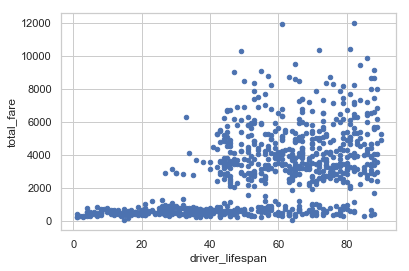

In [55]:
ax2 = driver_sum_total_fare.plot.scatter(x='driver_lifespan',
                       y='total_fare')

# Linear Regression

In [56]:
#all of these is to check if any correlation
driver_sum_total_fare['driver_lifespan'].corr(driver_sum_total_fare['rides'])

0.5303989111650756

In [57]:
driver_sum_total_fare['driver_lifespan'].corr(driver_sum_total_fare['total_fare'])

0.5249786972279635

In [58]:
driver_sum_total_fare['driver_lifespan'].corr(driver_sum_total_fare['ride_prime_time_sum'])

0.43281700030220704

In [59]:
driver_sum_total_fare['driver_lifespan'].corr(driver_sum_total_fare['duration_min_sum'])

0.5250489607629846

In [60]:
driver_sum_total_fare['driver_lifespan'].corr(driver_sum_total_fare['distance_mi_sum'])

0.5197765285398993

In [61]:
#Do not vary so STD = 0 DOES NOT CORRELATE
driver_sum_total_fare['driver_lifespan'].corr(driver_sum_total_fare['rides_per_day'])

-0.00873069204623196

In [62]:
#Creating the feature dataframe
X = pd.DataFrame(np.c_[driver_sum_total_fare['rides'],driver_sum_total_fare['total_fare'],driver_sum_total_fare['ride_prime_time_sum'],driver_sum_total_fare['duration_min_sum'],driver_sum_total_fare['distance_mi_sum']], columns = ['rides','total_fare','ride_prime_time_sum','duration_min_sum','distance_mi_sum'])

In [63]:
#Using the driver_lifespan as label
y = driver_sum_total_fare['driver_lifespan']

In [64]:
#Creating training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=9)

In [65]:
#running linear reg

lin_reg_mod = LinearRegression()

In [66]:
lin_reg_mod.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [67]:
pred = lin_reg_mod.predict(X_test)

In [ ]:
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))

test_set_r2 = r2_score(y_test, pred)

In [ ]:
#printing RMSE, accuracy
print(test_set_rmse)
print(test_set_r2)


17.186105986389286
0.3318131488029906


# Log Regression

In [1269]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, 
                                                    random_state=101)
#Creating training and testing 

In [1270]:
# train['labels'] = labels
# le_rides = LabelEncoder()
# le_fare = LabelEncoder()
# le_prime = LabelEncoder()
# le_dura = LabelEncoder()
# le_dist = LabelEncoder()
# le_life = LabelEncoder()
# le_label = LabelEncoder()
# train['rides'] = le_rides.fit_transform(train['rides'])
# train['total_fare'] = le_fare.fit_transform(train['total_fare'])
# train['ride_prime_time_sum'] = le_prime.fit_transform(train['ride_prime_time_sum'])
# train['duration_min_sum'] = le_dura.fit_transform(train['duration_min_sum'])
# train['distance_mi_sum'] = le_dist.fit_transform(train['distance_mi_sum'])
# train['driver_lifespan'] = le_life.fit_transform(train['driver_lifespan'])
# train['driver_id'] = le_label.fit_transform(train['driver_id'])


# test['rides'] = le_rides.fit_transform(train['rides'])
# test['total_fare'] = le_fare.fit_transform(train['total_fare'])
# test['ride_prime_time_sum'] = le_prime.fit_transform(train['ride_prime_time_sum'])
# test['duration_min_sum'] = le_dura.fit_transform(train['duration_min_sum'])
# test['distance_mi_sum'] = le_dist.fit_transform(train['distance_mi_sum'])
# test['driver_lifespan'] = le_life.fit_transform(train['driver_lifespan'])


In [1271]:
#Making log model
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(solver='liblinear', multi_class='ovr')
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
#some labels in y_true don't appear in predictions = possibly bad accuracy b/c they become 0
set(y_test) - set(predictions)

{2,
 8,
 9,
 12,
 13,
 14,
 16,
 18,
 20,
 22,
 24,
 25,
 29,
 30,
 31,
 33,
 41,
 42,
 44,
 47,
 51,
 55,
 58,
 60,
 62,
 63,
 64,
 68,
 75,
 77,
 80,
 84,
 85}

In [1272]:
from sklearn.metrics import f1_score
f1_score(y_test,predictions, average='weighted', labels=np.unique(predictions))

0.025678606904660548

In [1273]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, predictions, labels=[0,1]).ravel()

# Polynomial Regression

In [1274]:
X = pd.DataFrame(np.c_[driver_sum_total_fare['rides']], columns = ['rides'])
y = driver_sum_total_fare['driver_lifespan']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=9)

In [1275]:
lin = LinearRegression() 
  
lin.fit(X, y) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1276]:
poly = PolynomialFeatures(degree = 5) 
X_poly = poly.fit_transform(X) 

In [1277]:
poly.fit(X_poly, y) 

PolynomialFeatures(degree=5, include_bias=True, interaction_only=False,
                   order='C')

In [1278]:
lin2 = LinearRegression() 
lin2.fit(X_poly, y) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

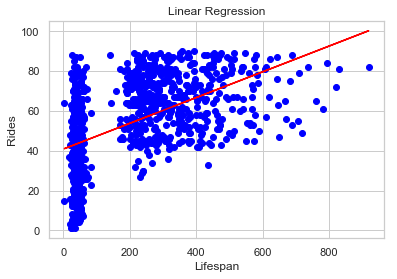

In [1279]:
plt.scatter(X, y, color = 'blue') 
  
plt.plot(X, lin.predict(X), color = 'red') 
plt.title('Linear Regression') 
plt.xlabel('Lifespan') 
plt.ylabel('Rides') 
  
plt.show() 

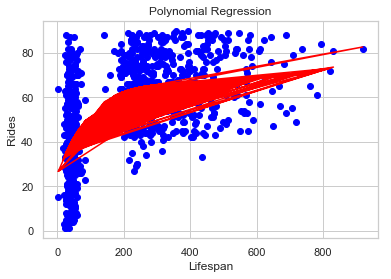

In [1280]:
plt.scatter(X, y, color = 'blue') 
  
plt.plot(X, lin2.predict(poly.fit_transform(X)), color = 'red') 
plt.title('Polynomial Regression') 
plt.xlabel('Lifespan') 
plt.ylabel('Rides') 
  
plt.show() 

In [1281]:
poly_features = PolynomialFeatures(degree=7)
  
  # transforms the existing features to higher degree features.
X_train_poly = poly_features.fit_transform(X_train)
  
  # fit the transformed features to Linear Regression
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
  
  # predicting on training data-set
y_train_predicted = poly_model.predict(X_train_poly)
  
  # predicting on test data-set
y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
  
  # evaluating the model on training dataset
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
r2_train = r2_score(y_train, y_train_predicted)
  
  # evaluating the model on test dataset
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
r2_test = r2_score(y_test, y_test_predict)
  
print("The model performance for the training set")
print("-------------------------------------------")
print("RMSE of training set is {}".format(rmse_train))
print("R2 score of training set is {}".format(r2_train))
  
print("\n")
  
print("The model performance for the test set")
print("-------------------------------------------")
print("RMSE of test set is {}".format(rmse_test))
print("R2 score of test set is {}".format(r2_test))


The model performance for the training set
-------------------------------------------
RMSE of training set is 17.768298587612904
R2 score of training set is 0.3405318786898087


The model performance for the test set
-------------------------------------------
RMSE of test set is 16.552860876373952
R2 score of test set is 0.38014646329489044


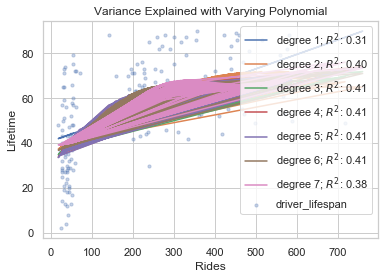

In [1282]:
# Polynomial Regression-nth order
from sklearn.pipeline import make_pipeline
plt.scatter(X_test, y_test, s=10, alpha=0.3)

for degree in [1,2,3,4,5,6,7]:

    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    model.fit(X_train,y_train)

    y_plot = model.predict(X_test)

    plt.plot(X_test, y_plot, label="degree %d" % degree +'; $R^2$: %.2f' % model.score(X_test, y_test))

plt.legend(loc='upper right')

plt.xlabel("Rides")

plt.ylabel("Lifetime")

plt.title("Variance Explained with Varying Polynomial")

plt.show()

In [1170]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
driver_sum_total_fare['rides'] = driver_sum_total_fare['rides'].apply(lambda x: x if x >= 5 else 0)
#driver_sum_total_fare['driver_lifespan'] = driver_sum_total_fare.rides.apply(lambda x: x if x >= 5 else 0)
driver_sum_total_fare.set_value(438, 'driver_lifespan', 0)
driver_sum_total_fare.set_value(421, 'driver_lifespan', 0)

,driver_id,ride_prime_time_sum,duration_min_sum,distance_mi_sum,total_fare,rides,driver_lifespan,t,rides_per_day
0,002be0ffdc997bd5c50703158b7c2491,5375,3687.300000,1081.362133,3453.419687,277,86,90,3.220930
1,007f0389f9c7b03ef97098422f902e62,625,341.616667,73.030237,308.994506,31,85,90,0.364706
2,011e5c5dfc5c2c92501b8b24d47509bc,675,486.750000,167.554285,468.927442,34,68,83,0.500000
3,0152a2f305e71d26cc964f8d4411add9,2050,2908.683333,914.183777,2569.866550,191,64,65,2.984375
4,01674381af7edd264113d4e6ed55ecda,4700,5957.383333,1940.938672,5287.086873,375,56,59,6.696429
...,...,...,...,...,...,...,...,...,...
832,ff419a3476e21e269e340b5f1f05414e,3100,4105.133333,1244.231288,3476.370782,242,61,62,3.967213
833,ff714a67ba8c6a108261cd81e3b77f3a,8625,7374.866667,1761.437928,6114.858170,485,81,91,5.987654
834,fff482c704d36a1afe8b8978d5486283,175,461.550000,108.363200,377.160834,35,34,80,1.029412
835,fffecccc49436c5389075b13209f0dfa,12050,5899.566667,1817.453191,5812.169994,406,51,52,7.960784


In [1171]:
driver_sum_total_fare[driver_sum_total_fare['rides'] < 5]

,driver_id,ride_prime_time_sum,duration_min_sum,distance_mi_sum,total_fare,rides,driver_lifespan,t,rides_per_day
421,7b625f643d0775f0ac4898e33235377b,0,28.533333,6.148456,25.691293,0,0,84,0.200000
438,7ff85c5c0e9324e28d1e0d0589c364bd,25,29.183333,14.957619,35.566946,0,0,69,0.046875


In [1172]:
# import lifetimes
# from lifetimes.plotting import *
# from lifetimes.utils import *
# #from lifetimes.estimation import *


count    837.000000
mean     220.075269
std      178.189151
min        0.000000
25%       44.000000
50%      224.000000
75%      330.000000
max      919.000000
Name: rides, dtype: float64
0.0023894862604540022


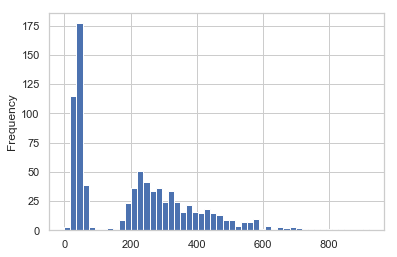

In [1173]:
driver_sum_total_fare['rides'].plot(kind='hist', bins=50)
print(driver_sum_total_fare['rides'].describe())
print(sum(driver_sum_total_fare['rides'] == 0)/float(len(driver_sum_total_fare)))

In [1174]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(driver_sum_total_fare['rides'], driver_sum_total_fare['driver_lifespan'], driver_sum_total_fare['t'])
print(bgf)

      fun: -1119.9457913924307
 hess_inv: array([[  1.79381563,   1.77253132,   5.26201299,   5.24969109],
       [  1.77253132,   2.40258042,   0.85670268,   0.84276921],
       [  5.26201299,   0.85670268, 590.76728974, 587.86331527],
       [  5.24969109,   0.84276921, 587.86331527, 586.61545788]])
      jac: array([-1.39914381e-04,  9.81400300e-05, -9.96786536e-06,  9.42549493e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 157
      nit: 49
     njev: 145
   status: 2
  success: False
        x: array([ 0.48694489, -5.40007585, 12.63068289, 18.36676784])


ConvergenceError: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.


In [1175]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

AttributeError: 'BetaGeoFitter' object has no attribute 'data'

<Figure size 864x576 with 0 Axes>

In [1176]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

AttributeError: 'BetaGeoFitter' object has no attribute 'data'

<Figure size 864x576 with 0 Axes>

In [1177]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

AttributeError: 'BetaGeoFitter' object has no attribute 'data'

In [1178]:
g = 10
individual = driver_sum_total_fare.loc[driver_sum_total_fare['driver_id'] =='007f0389f9c7b03ef97098422f902e62']
bgf.predict(g, driver_sum_total_fare['rides'], driver_sum_total_fare['driver_lifespan'], driver_sum_total_fare['t'])

AttributeError: 'BetaGeoFitter' object has no attribute 'predict'

In [1179]:
returning_customers_summary = driver_sum_total_fare[driver_sum_total_fare['rides']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

                          driver_id  ride_prime_time_sum  duration_min_sum  \
0  002be0ffdc997bd5c50703158b7c2491                 5375       3687.300000   
1  007f0389f9c7b03ef97098422f902e62                  625        341.616667   
2  011e5c5dfc5c2c92501b8b24d47509bc                  675        486.750000   
3  0152a2f305e71d26cc964f8d4411add9                 2050       2908.683333   
4  01674381af7edd264113d4e6ed55ecda                 4700       5957.383333   

   distance_mi_sum   total_fare  rides  driver_lifespan   t  rides_per_day  
0      1081.362133  3453.419687    277               86  90       3.220930  
1        73.030237   308.994506     31               85  90       0.364706  
2       167.554285   468.927442     34               68  83       0.500000  
3       914.183777  2569.866550    191               64  65       2.984375  
4      1940.938672  5287.086873    375               56  59       6.696429  
835


In [1180]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['rides'],
        returning_customers_summary['total_fare'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 835 subjects, p: 0.02, q: 21.65, v: 5112603.76>


In [1185]:
print(ggf.conditional_expected_average_profit(
        driver_sum_total_fare['rides'],
        driver_sum_total_fare['total_fare']))

0      4316.637944
1      4415.667535
2      4409.749832
3      4245.030561
4      4717.588114
          ...     
832    4342.726022
833    5005.142888
834    4403.604950
835    4867.971129
836    4510.404609
Length: 837, dtype: float64


In [1401]:
driver_sum_total_fare[driver_sum_total_fare['driver_id'] == '002be0ffdc997bd5c50703158b7c2491']

,driver_id,ride_prime_time_sum,duration_min_sum,distance_mi_sum,total_fare,rides,driver_lifespan,t,rides_per_day
0,002be0ffdc997bd5c50703158b7c2491,5375,3687.3,1081.362133,3453.419687,277,86,90,3.22093


,driver_id,driver_onboard_date,ride_id,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at
0,d967f5296732fa55266b5f1314e7447b,2016-04-09 00:00:00,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:19,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 09:44:33,2016-06-13 10:03:05
1,0656192a402808805282e60761bda088,2016-04-30 00:00:00,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:21,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:26:18,2016-05-14 05:34:17
2,c468a648519cd42da75e6aa9dadf733e,2016-04-01 00:00:00,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:09,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:47:32,2016-05-16 15:54:18
3,689bdf87fb2de49f98bf4946cfaa5068,2016-04-04 00:00:00,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:36,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:35:15,2016-05-11 19:40:47
4,eece82fe623b4bb335a9b9e20eb0ca54,2016-04-28 00:00:00,00012759befd5d34a0609800f6a1ee59,2016-05-31 15:44:56,2016-05-31 15:45:05,2016-05-31 15:46:22,2016-05-31 15:46:23,2016-05-31 15:59:26
...,...,...,...,...,...,...,...,...
184204,5ccc0e6dc9c7475caf785cdce7b8eb7a,2016-04-05 00:00:00,fffe942c46a5b2039fa01ba4c3d390e8,2016-05-17 19:56:09,2016-05-17 19:56:13,2016-05-17 19:58:50,2016-05-17 19:58:52,2016-05-17 20:11:11
184205,fb903879c556260ae2604ae0c45cb92a,2016-05-02 00:00:00,fffebb46effb90ce758fdff68b569355,2016-06-16 09:57:07,2016-06-16 09:57:12,2016-06-16 09:58:54,2016-06-16 09:58:57,2016-06-16 10:15:08
184206,3a1d9fb7a8cfd55ae38d1b4fb1520d1f,2016-05-02 00:00:00,ffff9c38173ddfa17bdd115c463e329f,2016-06-03 18:34:00,2016-06-03 18:34:07,2016-06-03 18:35:20,2016-06-03 18:35:22,2016-06-03 18:50:08
184207,36de1e085fbd8f354dd3192571cece32,2016-04-19 00:00:00,ffff9e431f7fade54b2550ac19ab6e64,2016-06-12 04:00:10,2016-06-12 04:00:10,2016-06-12 04:04:35,2016-06-12 04:04:37,2016-06-12 04:15:42


# LTV

In [133]:
merged_driver

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,duration_min,distance_mi,fare_duration,fare_distance,total_fare,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,5.450000,1.125301,1.199000,1.294096,7.489644,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:22:07,2016-04-23 02:16:40,2016-04-23 02:13:50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,13.483333,2.089046,2.966333,2.402403,9.118736,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:17:30,2016-03-29 19:04:01,2016-03-29 19:00:49
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,9.533333,2.039336,2.097333,2.345237,8.192570,2016-06-21 11:56:39,2016-06-21 12:01:32,2016-06-21 12:11:07,2016-06-21 12:01:35,2016-06-21 11:56:31
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,55.633333,40.564898,12.239333,46.649632,77.361207,2016-05-19 09:15:33,2016-05-19 09:18:20,2016-05-19 10:13:58,2016-05-19 09:18:20,2016-05-19 09:15:29
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,13.716667,2.556938,3.017667,2.940478,15.666290,2016-04-20 22:05:32,2016-04-20 22:07:03,2016-04-20 22:20:45,2016-04-20 22:07:02,2016-04-20 22:05:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184814,ffff51a71f2f185ec5e97d59dbcd7a78,fc717192b3512767269ff5a54b97af05,10127,1336,0,22.266667,6.292614,4.898667,7.236506,15.885173,2016-06-18 01:15:52,2016-06-18 01:21:11,2016-06-18 01:43:30,2016-06-18 01:21:14,2016-06-18 01:14:52
184815,ffff51a71f2f185ec5e97d59dbcd7a78,fd6fa5f9265d2cf83936ead663f9e0e7,1908,445,0,7.416667,1.185574,1.631667,1.363410,6.745077,2016-06-23 23:52:08,2016-06-23 23:59:04,2016-06-24 00:06:33,2016-06-23 23:59:08,2016-06-23 23:51:55
184816,ffff51a71f2f185ec5e97d59dbcd7a78,fe0857c43025264d337dfe1d8463e503,4039,875,0,14.583333,2.509713,3.208333,2.886170,9.844504,2016-05-31 19:26:42,2016-05-31 19:29:08,2016-05-31 19:43:46,2016-05-31 19:29:11,2016-05-31 19:26:34
184817,ffff51a71f2f185ec5e97d59dbcd7a78,ff0db0ca4557bf5b05b4da6f660a1ac1,4760,777,0,12.950000,2.957721,2.849000,3.401379,10.000379,2016-05-15 00:51:59,2016-05-15 00:52:05,2016-05-15 01:05:04,2016-05-15 00:52:07,2016-05-15 00:51:53


In [196]:
merged_driver['picked_up_at']=pd.to_datetime(timestamps_driver['picked_up_at'].str.strip(), format='%Y-%m-%d %H:%M:%S')
driver_1m = merged_driver[(merged_driver.picked_up_at < date(2016,4,28)) & (merged_driver.picked_up_at >= date(2016,3,28))].reset_index(drop=True)
driver_2m = merged_driver[(merged_driver.picked_up_at >= date(2011,4,28)) & (merged_driver.picked_up_at < date(2016, 6, 27))].reset_index(drop=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.



In [197]:
driver_user = pd.DataFrame(driver_1m['driver_id'].unique())
driver_user.columns = ['driver_id']

In [198]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [199]:
driver_max = driver_1m.groupby('driver_id').picked_up_at.max().reset_index()
driver_max.columns = ['driver_id','driver_max']
driver_max['Recency'] = (driver_max['driver_max'].max() - driver_max['driver_max']).dt.days
driver_user = pd.merge(driver_user, driver_max[['driver_id','Recency']], on='driver_id')

kmeans = KMeans(n_clusters=4)
kmeans.fit(driver_user[['Recency']])
driver_user['RecencyCluster'] = kmeans.predict(driver_user[['Recency']])

driver_user = order_cluster('RecencyCluster', 'Recency',driver_user,False)

In [200]:
driver_freq = driver_1m.groupby('driver_id').picked_up_at.count().reset_index()
driver_freq.columns = ['driver_id','Frequency']
driver_user = pd.merge(driver_user, driver_freq, on='driver_id')

kmeans = KMeans(n_clusters=4)
kmeans.fit(driver_user[['Frequency']])
driver_user['FrequencyCluster'] = kmeans.predict(driver_user[['Frequency']])

driver_user = order_cluster('FrequencyCluster', 'Frequency',driver_user,True)

In [201]:
driver_1m

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,duration_min,distance_mi,fare_duration,fare_distance,total_fare,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,5.450000,1.125301,1.199000,1.294096,7.489644,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:22:07,2016-04-23 02:16:40,2016-04-23 02:13:50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,13.483333,2.089046,2.966333,2.402403,9.118736,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:17:30,2016-03-29 19:04:01,2016-03-29 19:00:49
2,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,13.716667,2.556938,3.017667,2.940478,15.666290,2016-04-20 22:05:32,2016-04-20 22:07:03,2016-04-20 22:20:45,2016-04-20 22:07:02,2016-04-20 22:05:30
3,002be0ffdc997bd5c50703158b7c2491,04053c0ed21761e07f0b869cab5b7dd0,1575,347,0,5.783333,0.978658,1.272333,1.125456,6.147790,2016-04-16 22:28:08,2016-04-16 22:29:10,2016-04-16 22:35:02,2016-04-16 22:29:15,2016-04-16 22:28:05
4,002be0ffdc997bd5c50703158b7c2491,0534d432e0186625f623aaee57af98be,3056,687,25,11.450000,1.898907,2.519000,2.183743,9.628428,2016-04-01 21:53:12,2016-04-01 21:54:15,2016-04-01 22:05:41,2016-04-01 21:54:14,2016-04-01 21:53:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31665,fff482c704d36a1afe8b8978d5486283,ddd4cdc8e30a7b277464214debf688d3,2920,774,0,12.900000,1.814400,2.838000,2.086560,8.674560,2016-04-15 08:49:08,2016-04-15 08:52:33,2016-04-15 09:05:29,2016-04-15 08:52:35,2016-04-15 08:48:59
31666,fff482c704d36a1afe8b8978d5486283,de7ff831091364220f392148e7cc9da9,2397,961,0,16.016667,1.489424,3.523667,1.712837,8.986504,2016-04-21 12:06:12,2016-04-21 12:12:44,2016-04-21 12:28:46,2016-04-21 12:12:45,2016-04-21 12:06:03
31667,fff482c704d36a1afe8b8978d5486283,f4ed6a9def9d352b5ef319df6eb76841,4778,859,0,14.316667,2.968906,3.149667,3.414242,10.313908,2016-04-19 13:55:35,2016-04-19 13:58:14,2016-04-19 14:12:38,2016-04-19 13:58:19,2016-04-19 13:55:27
31668,fff482c704d36a1afe8b8978d5486283,f613ea12a08b5bf5a5b6d86baf94ff9f,1409,356,0,5.933333,0.875510,1.305333,1.006837,6.062170,2016-04-21 12:30:19,2016-04-21 12:34:17,2016-04-21 12:40:17,2016-04-21 12:34:21,2016-04-21 12:30:05


In [202]:
driver_rev = driver_1m.groupby('driver_id').total_fare.sum().reset_index()
driver_user = pd.merge(driver_user, driver_rev, on='driver_id')

kmeans = KMeans(n_clusters=4)
kmeans.fit(driver_user[['total_fare']])
driver_user['RevenueCluster'] = kmeans.predict(driver_user[['total_fare']])
driver_user = order_cluster('RevenueCluster', 'total_fare',driver_user,True)

In [203]:
driver_user['OverallScore'] = driver_user['RecencyCluster'] + driver_user['FrequencyCluster'] + driver_user['RevenueCluster']
driver_user['Segment'] = 'Low-Value'
driver_user.loc[driver_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
driver_user.loc[driver_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [221]:
driver_user_2m = driver_2m.groupby('driver_id')['total_fare'].sum().reset_index()
driver_user_2m.columns = ['driver_id','m2_fare']
plot_data = [
    go.Histogram(
        x=driver_user_2m.query('m2_fare < 10000')['m2_fare']
    )
]

plot_layout = go.Layout(
    title=go.layout.Title(
        text='2m Revenue',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Revenue',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Driver amount',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
    
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [205]:
driver_merge = pd.merge(driver_user, driver_user_2m, on='driver_id', how='left')

In [206]:
driver_graph = driver_merge.query("m2_fare < 30000")

plot_data = [
    go.Scatter(
        x=driver_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=driver_graph.query("Segment == 'Low-Value'")['total_fare'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=driver_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=driver_graph.query("Segment == 'Mid-Value'")['total_fare'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=driver_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=driver_graph.query("Segment == 'High-Value'")['total_fare'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "2m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [207]:
driver_merge = driver_merge[driver_merge['m2_fare']<driver_merge['m2_fare'].quantile(0.99)]

In [208]:

kmeans = KMeans(n_clusters=3)
kmeans.fit(driver_merge[['m2_fare']])
driver_merge['LTVCluster'] = kmeans.predict(driver_merge[['m2_fare']])

#order cluster number based on LTV
driver_sum_total_fare = order_cluster('LTVCluster', 'm2_fare',driver_merge,True)

#creatinga new cluster dataframe
driver_cluster = driver_merge.copy()

#see details of the clusters
driver_merge.groupby('LTVCluster')['m2_fare'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,223.0,587.667693,292.012279,25.691293,403.764583,512.068265,702.153250,2008.995867
1,238.0,3538.661140,736.421503,2106.324904,2974.466206,3451.917150,4094.251948,4976.232554
2,108.0,6422.761629,1151.642844,5003.337946,5422.282513,6176.557411,7216.702326,9433.435012


In [209]:
driver_class = pd.get_dummies(driver_cluster)
#calculate and show correlations
corr_matrix = driver_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

#create X and y, X will be feature set and y is the label - LTV
X = driver_class.drop(['LTVCluster','m2_fare'],axis=1)
y = driver_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [210]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.89
Accuracy of XGB classifier on test set: 0.62
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.60      0.46      0.52        13
           2       0.20      1.00      0.33         1

    accuracy                           0.62        29
   macro avg       0.53      0.73      0.54        29
weighted avg       0.68      0.62      0.64        29

